Import modules

In [1]:
from lib.datasets import get_stock_price,train_test_split,get_OU,rolling_window_1D
from lib.aug import apply_augmentations,parse_augmentations,sig_normal
import torch
from torch import nn
import torch.nn.functional as F
from lib.utils import set_seed
import signatory
from models.vae import VAE, VAE_train
from models.betavae import BetaVAE, BetaVAE_train
from models.infovae import InfoVAE, InfoVAE_train
from models.wae import WAE,WAE_train
from lib.metrics import mmd_loss
import numpy as np
import matplotlib.pyplot as plt

In [2]:
set_seed(0)

The considered truncated signature degree.

In [3]:
sig_degree = [3,4,5]

Get synthetic data/

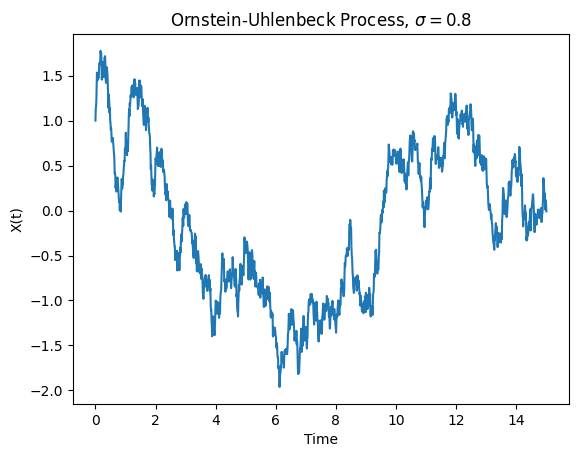

In [4]:
T = 15
dt = 0.01
N = int(T/dt)
sigma_1 = 0.8
ou_process_1 = get_OU(T=T,sigma=sigma_1).astype(np.float32)

# Plot the result
plt.plot(np.linspace(0, T, N), ou_process_1)
plt.title("Ornstein-Uhlenbeck Process, $\sigma=0.8$")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()


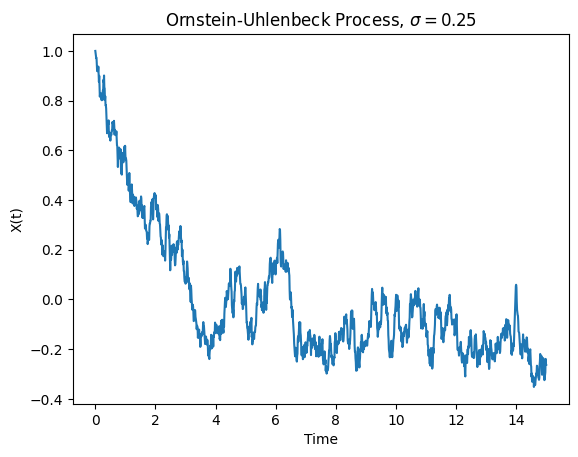

In [5]:
sigma_2 = 0.25
ou_process_2 = get_OU(T=T,sigma=sigma_2).astype(np.float32)

# Plot the result
plt.plot(np.linspace(0, T, N), ou_process_2)
plt.title("Ornstein-Uhlenbeck Process, $\sigma=0.25$")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()

In [6]:
sig_degree = [3,4,5]
sig_config = {
    "augmentations": [{"name": "LeadLag"}],
    "device" : "cuda",
    "depth" : sig_degree[0], # degree = 3
}

Get path augmentations.

In [7]:
if sig_config["augmentations"] is not None:
    sig_config["augmentations"] = parse_augmentations(sig_config.get('augmentations'))

Data preprocessing.
- Apply rolling window.
- Split training data and testing data.
- Apply path augmentations to original path.
- Calculate signature.
- Normalize signatures.
- Pass to CUDA.

In [8]:
tensor_data_1 = rolling_window_1D(torch.from_numpy(ou_process_1),window_size=30).view(-1,30,1)
tensor_data_2 = rolling_window_1D(torch.from_numpy(ou_process_2),window_size=30).view(-1,30,1)


x_real_train_1, x_real_test_1 = train_test_split(tensor_data_1, train_test_ratio=0.8, device=sig_config["device"])
print("x_real_train_1 shape {}, x_real_test shape {}".format(x_real_train_1.shape,x_real_test_1.shape))
x_real_train_2, x_real_test_2 = train_test_split(tensor_data_2, train_test_ratio=0.8, device=sig_config["device"])
print("x_real_train_1 shape {}, x_real_test shape {}".format(x_real_train_2.shape,x_real_test_2.shape))

if sig_config["augmentations"] is not None:
    # Print the tensor shape after each augmentation
    x_aug_train_1, x_aug_test_1 = apply_augmentations(x_real_train_1,sig_config["augmentations"]), apply_augmentations(x_real_test_1,sig_config["augmentations"])
    x_aug_train_2, x_aug_test_2 = apply_augmentations(x_real_train_2,sig_config["augmentations"]), apply_augmentations(x_real_test_2,sig_config["augmentations"])
print("After augmentation shape:",x_aug_train_1.shape)

# To signature
x_sig_train_1, x_sig_test_1 = signatory.signature(x_aug_train_1,sig_config["depth"]),signatory.signature(x_aug_test_1,sig_config["depth"])
x_sig_train_2, x_sig_test_2 = signatory.signature(x_aug_train_2,sig_config["depth"]),signatory.signature(x_aug_test_2,sig_config["depth"])
print("x_sig_train shape {}, x_sig_test shape {}".format(x_sig_train_1.shape,x_sig_test_1.shape))
input_dim = x_sig_train_1.shape[1]
print("input_dim: {}".format(input_dim))

# Normalize
x_sig_train_1, x_sig_test_1 = sig_normal(x_sig_train_1,True).to(sig_config["device"]), sig_normal(x_sig_test_1,True).to(sig_config["device"])
x_sig_train_2, x_sig_test_2 = sig_normal(x_sig_train_2,True).to(sig_config["device"]), sig_normal(x_sig_test_2,True).to(sig_config["device"])

Tensor shape before rolling: torch.Size([1500])
Tensor shape after rolling: torch.Size([1471, 30])
Tensor shape before rolling: torch.Size([1500])
Tensor shape after rolling: torch.Size([1471, 30])
x_real_train_1 shape torch.Size([1176, 30, 1]), x_real_test shape torch.Size([295, 30, 1])
x_real_train_1 shape torch.Size([1176, 30, 1]), x_real_test shape torch.Size([295, 30, 1])
torch.Size([1176, 59, 2])
torch.Size([295, 59, 2])
torch.Size([1176, 59, 2])
torch.Size([295, 59, 2])
After augmentation shape: torch.Size([1176, 59, 2])
x_sig_train shape torch.Size([1176, 14]), x_sig_test shape torch.Size([295, 14])
input_dim: 14


In [9]:
# For degree = 3
hidden_dim_degree3 = [input_dim,7,3] # input_dim = 14

# For degree = 4
hidden_dim_degree4 = [input_dim,15,7] # input_dim = 30

# For degree = 5
hidden_dim_degree5 = [input_dim,32,16] # input_dim = 62

Set degree = 3. Train models for $\sigma=0.8$

In [10]:
# VAE
model_vae = VAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,device="cuda",hidden_dims=hidden_dim_degree3)
vae_optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4)
VAE_train(model_vae,optimizer=vae_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 1.00
Epoch 100 loss 0.95
Epoch 200 loss 0.63
Epoch 300 loss 1.71
Epoch 400 loss 0.99
min_loss: 0.51


In [11]:
# Beta-VAE
model_betavae = BetaVAE(x_sig_train_1,6000,128,beta=3.5,device='cuda',hidden_dims=hidden_dim_degree3)
beta_optimizer = torch.optim.Adam(model_betavae.parameters(), lr=1e-4)
BetaVAE_train(model=model_betavae,optimizer=beta_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Beta: 3.5
Epoch 0 loss 17.00
Epoch 100 loss 16.08
Epoch 200 loss 11.09
Epoch 300 loss 29.23
Epoch 400 loss 11.37
Epoch 500 loss 14.60
Epoch 600 loss 17.61
Epoch 700 loss 16.38
Epoch 800 loss 16.44
Epoch 900 loss 12.98
min_loss: 7.16


In [12]:
# Info-VAE
model_infovae = InfoVAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
info_optimizer = torch.optim.Adam(model_infovae.parameters(), lr=1e-4) 
InfoVAE_train(model_infovae,info_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 1.05
Epoch 100 loss 1.35
Epoch 200 loss 1.08
Epoch 300 loss 1.30
Epoch 400 loss 1.26
min_loss: 0.86


In [13]:
# WAE-MMD
model_waemmd = WAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
cvae_optimizer = torch.optim.Adam(model_waemmd.parameters(), lr=1e-4) 
WAE_train(model_waemmd,cvae_optimizer)

Epoch 0 loss 1.03
Epoch 100 loss 1.29
Epoch 200 loss 1.30
Epoch 300 loss 1.28
Epoch 400 loss 1.76
Epoch 500 loss 1.11
Epoch 600 loss 1.18
Epoch 700 loss 1.12
min_loss: 0.55


Evaluate.

In [14]:
KLD = nn.KLDivLoss(reduction="batchmean")

In [15]:
models = [model_vae,model_betavae,model_infovae,model_waemmd]
for model in models:
    _, _, z = model_vae.encode(x_sig_test_1)
    reconstructed_sig = model_vae.decode(z)
    reconstructed_sig = sig_normal(reconstructed_sig,True)

    # Mean of L2 norm over the batch dimension
    L2 = F.mse_loss(x_sig_test_1,reconstructed_sig)
    # Mean of JS divergence over the batch dimension
    js = (KLD(x_sig_test_1,reconstructed_sig)+KLD(reconstructed_sig,x_sig_test_1))/2
    # signature MMD
    mmd = mmd_loss(x_sig_test_1,reconstructed_sig)

    print("L2 ({}): {:.3f}".format(model.type,L2.item()))
    print("JS ({}): {:.3f}".format(model.type,js.item()))
    print("mmd ({}): {:.3f}".format(model.type,mmd.item()))

L2 (VAE): 1.979
JS (VAE): 1.008
mmd (VAE): -0.095
L2 (Beta-VAE): 1.912
JS (Beta-VAE): 0.727
mmd (Beta-VAE): -0.095
L2 (Info-VAE): 2.043
JS (Info-VAE): 1.516
mmd (Info-VAE): -0.095
L2 (WAE): 1.934
JS (WAE): 0.873
mmd (WAE): -0.095


Set degree = 3. Train models for $\sigma=0.25$

In [16]:
# VAE
model_vae = VAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,device="cuda",hidden_dims=hidden_dim_degree3)
vae_optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4)
VAE_train(model_vae,optimizer=vae_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 1.38
Epoch 100 loss 0.67
Epoch 200 loss 0.92
Epoch 300 loss 1.59
Epoch 400 loss 0.72
Epoch 500 loss 1.52
Epoch 600 loss 2.17
Epoch 700 loss 1.16
Epoch 800 loss 1.34
min_loss: 0.50


In [17]:
# Beta-VAE
model_betavae = BetaVAE(x_sig_train_2,6000,128,beta=3.5,device='cuda',hidden_dims=hidden_dim_degree3)
beta_optimizer = torch.optim.Adam(model_betavae.parameters(), lr=1e-4)
BetaVAE_train(model=model_betavae,optimizer=beta_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Beta: 3.5
Epoch 0 loss 11.63
Epoch 100 loss 14.01
Epoch 200 loss 9.96
Epoch 300 loss 13.32
Epoch 400 loss 16.70
min_loss: 7.72


In [18]:
# Info-VAE
model_infovae = InfoVAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
info_optimizer = torch.optim.Adam(model_infovae.parameters(), lr=1e-4) 
InfoVAE_train(model_infovae,info_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 1.12
Epoch 100 loss 1.70
Epoch 200 loss 1.59
Epoch 300 loss 1.77
Epoch 400 loss 1.16
Epoch 500 loss 1.27
Epoch 600 loss 1.44
Epoch 700 loss 1.14
Epoch 800 loss 0.75
Epoch 900 loss 1.51
Epoch 1000 loss 1.33
min_loss: 0.67


In [19]:
# WAE-MMD
model_waemmd = WAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
cvae_optimizer = torch.optim.Adam(model_waemmd.parameters(), lr=1e-4) 
WAE_train(model_waemmd,cvae_optimizer)

Epoch 0 loss 1.35
Epoch 100 loss 1.84
Epoch 200 loss 1.06
Epoch 300 loss 0.98
Epoch 400 loss 0.82
Epoch 500 loss 1.90
Epoch 600 loss 1.29
Epoch 700 loss 1.65
Epoch 800 loss 1.27
Epoch 900 loss 0.97
Epoch 1000 loss 0.99
Epoch 1100 loss 1.67
Epoch 1200 loss 0.90
Epoch 1300 loss 0.95
Epoch 1400 loss 0.94
min_loss: 0.57


In [20]:
models = [model_vae,model_betavae,model_infovae,model_waemmd]
for model in models:
    _, _, z = model_vae.encode(x_sig_test_2)
    reconstructed_sig = model_vae.decode(z)
    reconstructed_sig = sig_normal(reconstructed_sig,True)

    # Mean of L2 norm over the batch dimension
    L2 = F.mse_loss(x_sig_test_2,reconstructed_sig)
    # Mean of JS divergence over the batch dimension
    js = (KLD(x_sig_test_2,reconstructed_sig)+KLD(reconstructed_sig,x_sig_test_2))/2
    # signature MMD
    mmd = mmd_loss(x_sig_test_2,reconstructed_sig)

    print("L2 ({}): {:.3f}".format(model.type,L2.item()))
    print("JS ({}): {:.3f}".format(model.type,js.item()))
    print("mmd ({}): {:.3f}".format(model.type,mmd.item()))

L2 (VAE): 2.045
JS (VAE): 0.819
mmd (VAE): -0.095
L2 (Beta-VAE): 2.108
JS (Beta-VAE): 1.096
mmd (Beta-VAE): -0.095
L2 (Info-VAE): 2.077
JS (Info-VAE): 1.066
mmd (Info-VAE): -0.095
L2 (WAE): 2.081
JS (WAE): 0.986
mmd (WAE): -0.095
